In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import cna
import pp
np.random.seed(0)

In [75]:
info = [
    ['RA', '/data/srlab1/laurie-yakir/notch.real/notch_CNAready.h5ad', 3, 0.5, 'X_umap'],
    ['Sepsis', '/data/srlab/lrumker/MCSC_Project/sepsis_data/pbmc.h5ad', 4, 0.2, 'X_tsne'],
    ['TB', '/data/srlab1/laurie-yakir/tbru.real/2.munged/harmcca20.h5ad', 7, 0.1, 'X_umap']
]

Transforming to str index.


reading /data/srlab1/laurie-yakir/notch.real/notch_CNAready.h5ad
	taking step 1
	taking step 2
	taking step 3
reading /data/srlab/lrumker/MCSC_Project/sepsis_data/pbmc.h5ad
	taking step 1
	taking step 2
	taking step 3
	taking step 4
reading /data/srlab1/laurie-yakir/tbru.real/2.munged/harmcca20.h5ad
	taking step 1
	taking step 2
	taking step 3
	taking step 4
	taking step 5
	taking step 6
	taking step 7


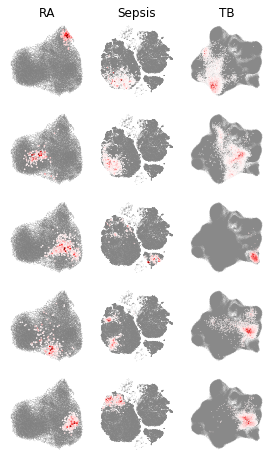

In [76]:
n_nbhd = 5
fig, axs = plt.subplots(n_nbhd, 3, figsize=(3*1.3, n_nbhd*1.3))

for a, (name, dfile, nsteps, size, rep) in enumerate(info):
    print('reading', dfile)
    d = cna.read(dfile)
    pp.umapprops['s'] = size
    s = np.zeros((len(d), n_nbhd))
    for i, j in enumerate(np.random.choice(len(d), n_nbhd, replace=False)):
        s[j, i] = 1
    s = cna.tl.diffuse(d, s, nsteps).T

    for i, (ax, nbhd) in enumerate(zip(axs[:,a], s)):
        if i == 0:
            ax.set_title(name)
        threshold = sorted(nbhd)[np.where(np.cumsum(sorted(nbhd)) > 0.3)[0][0]] # the intensity above which we'll get 70% of the mass of the nbhd
        mask = nbhd > threshold
        ax.axis('off')
        ax.scatter(*d.obsm[rep].T, alpha=0.6, color='gray', **pp.umapprops)
        ix = np.argsort(nbhd[mask])
        ax.scatter(*d.obsm[rep][mask][ix].T, c=nbhd[mask][ix], cmap='seismic', vmin=-max(nbhd), vmax=max(nbhd), alpha=1,
                  s=pp.umapprops['s']*5, edgecolors='none', rasterized=True)
    del d
    gc.collect()

plt.tight_layout()
plt.savefig('../_figs/suppfig.misc.nbhds.pdf')

In [64]:
n_nbhd = 100
nbhd_sizes = pd.DataFrame(columns=['Dataset', '# cells', '# steps', 'Avg. nbhd. size'])

for a, (name, dfile, nsteps, _, rep) in enumerate(info):
    print('reading', dfile)
    d = cna.read(dfile)
    s = np.zeros((len(d), n_nbhd))
    for i, j in enumerate(np.random.choice(len(d), n_nbhd, replace=False)):
        s[j, i] = 1
    s = cna.tl.diffuse(d, s, nsteps).T

    sizes = []
    for nbhd in s:
        print('.', end='')
        threshold = sorted(nbhd)[np.where(np.cumsum(sorted(nbhd)) > 0.3)[0][0]] # the intensity above which we'll get 70% of the mass of the nbhd
        mask = nbhd > threshold
        sizes.append(mask.sum())
    print('')
    
    nbhd_sizes = nbhd_sizes.append({
        'Dataset': name,
        '# cells': len(d),
        '# steps': int(nsteps),
        'Avg. nbhd. Size': np.mean(sizes)},
        ignore_index=True)
    del d, s
    gc.collect()

nbhd_sizes

Transforming to str index.


reading /data/srlab1/laurie-yakir/notch.real/notch_CNAready.h5ad
	taking step 1
	taking step 2
	taking step 3
....................................................................................................
reading /data/srlab/lrumker/MCSC_Project/sepsis_data/pbmc.h5ad
	taking step 1
	taking step 2
	taking step 3
	taking step 4
....................................................................................................
reading /data/srlab1/laurie-yakir/tbru.real/2.munged/harmcca20.h5ad
	taking step 1
	taking step 2
	taking step 3
	taking step 4
	taking step 5
	taking step 6
	taking step 7
....................................................................................................


,Dataset,# cells,# steps,Avg. nbhd. size,# Steps,Avg. Nbhd. Size
0,RA,27216,NaN,NaN,3.0,336.43
1,Sepsis,102814,NaN,NaN,4.0,1503.33
2,TB,500089,NaN,NaN,7.0,12183.74


In [80]:
nbhd_sizes.to_latex('../_tables/supptable.misc.nbhds.tex', index=False, escape=True, bold_rows=True)